# STOR 120: Final Exam(Essay Part)

60 points total

**Directions:** The exam is open book, notes, course materials, internet, and all things that are not direct communication with others. Just as with all course assignments, you will submit exams to Gradescope as Jupyter Notebooks with the ipynb file extension. To receive full credit, you should show all of your code used to answer each question. 

**Make sure to view your submission in Gradescope and verify that it is the correct file and has the format that you intended it to have, including all code being shown and run.**

**Your work WILL be graded based on ACCURACY and sound demonstration of the techniques learned in this class. Not mere completion. Please exercise care while working on the problems**


## Bone Mineral Density


Bone density, or bone mineral density (BMD), is the amount of bone mineral in bone tissue. The concept is of mass of mineral per volume of bone (relating to density in the physics sense), although clinically it is measured by proxy according to optical density per square centimetre of bone surface upon imaging. Bone density measurement is used in clinical medicine as an indirect indicator of osteoporosis and fracture risk. It is measured by a procedure called densitometry, often performed in the radiology or nuclear medicine departments of hospitals or clinics. The measurement is painless and non-invasive and involves low radiation exposure. Measurements are most commonly made over the lumbar spine and over the upper part of the hip. The forearm may be scanned if the hip and lumbar spine are not accessible.

https://en.wikipedia.org/wiki/Bone_density

**Run the cell below to import the needed modules and dataset**

In [118]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

import warnings
warnings.simplefilter('ignore', FutureWarning)

BMD = Table.read_table('https://raw.githubusercontent.com/JA-McLean/STOR120/master/data/bmd.csv')
BMD.show(5)

id,age,sex,fracture,weight_kg,height_cm,medication,waiting_time,bmd
469,57.0528,F,no fracture,64,155.5,Anticonvulsant,18,0.8793
8724,75.7412,F,no fracture,78,162,No medication,56,0.7946
6736,70.7789,M,no fracture,73,170.5,No medication,10,0.9067
24180,78.2472,F,no fracture,60,148,No medication,14,0.7112
17072,54.1919,M,no fracture,55,161,No medication,20,0.7909


## 1. Exploratory Data Analysis *(18 pts total)*

**Question 1.1.** Construct a table `BMD_means` with two rows and four columns. There should be one row those in the dataset with a `fracture` and another for those with`no fracture` The columns should be if there was a fracture, mean ages, mean weights, and mean bone mineral densities (bmd). *(3 pts)*

In [119]:
BMD_means = BMD.select('fracture', 'age', 'weight_kg', 'bmd').group('fracture', np.mean)
BMD_means

fracture,age mean,weight_kg mean,bmd mean
fracture,69.7713,58.41,0.623308
no fracture,61.0518,67.2941,0.850245


**Question 1.2.** Construct a table `BMD_SU`. This table should contain the columns `sex`, `fracture`, and `medication` from the `BMD` table, as well as columns of the quantitaive variables (`age`, `weight_kg`, `height_cm`, and `bmd`) in standard units. *(3
pts)*

In [120]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

In [121]:
BMD_SU = BMD.select('sex', 'fracture', 'medication').with_columns(
    'age SU', standard_units(BMD.column('age')), 
    'weight_kg SU', standard_units(BMD.column('weight_kg')),
    'height_cm SU', standard_units(BMD.column('height_cm')),
    'bmd SU', standard_units(BMD.column('bmd')))
BMD_SU

sex,fracture,medication,age SU,weight_kg SU,height_cm SU,bmd SU
F,no fracture,Anticonvulsant,-0.533977,-0.0578702,-0.601464,0.579369
F,no fracture,No medication,0.982904,1.1592,0.220824,0.0692374
M,no fracture,No medication,0.580128,0.724535,1.29612,0.744394
F,no fracture,No medication,1.1863,-0.405606,-1.55026,-0.433065
M,no fracture,No medication,-0.766186,-0.840276,0.0943179,0.0469529
M,no fracture,No medication,1.0995,0.0290637,0.979858,-0.319234
M,no fracture,No medication,-0.604766,1.07227,-0.158694,1.36414
F,no fracture,No medication,-1.11323,-0.49254,-1.29725,-0.313813
M,no fracture,Glucocorticoids,0.387723,-0.0578702,0.853352,-0.564964
M,no fracture,No medication,0.213072,0.637601,-0.0954407,0.984705


**Question 1.3.** What is the mean `bmd` for males on no medication over the age of 65? Assign this float value to `Males_over_65_bmd`. *(3 pts)*

In [122]:
Males_over_65_bmd = np.mean(BMD.where('sex', 'M').where('medication', 'No medication').where('age', are.above(65)).column('bmd'))
Males_over_65_bmd

0.78056774129032269

**Question 1.4.** What proportion of the females on no medication over the age of 65 in the dataset have had a fracture? Assign this float value to `fracture_prop`. *(3 pts)*

In [123]:
fit_requirements = BMD.where('sex', 'F').where('medication', 'No medication').where('age', are.above(65))
fracture_prop = (fit_requirements.where('fracture', 'fracture')).num_rows / (fit_requirements).num_rows
fracture_prop

0.42857142857142855

**Question 1.5.** Construct a scatter plot with ages on the horizontal axis and bmd on the vertical axis (using the original `BMD` table). Include the best fit line in this plot. *(3 pts)*

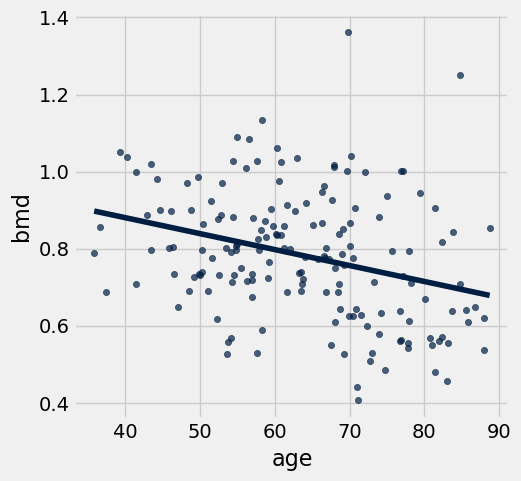

In [124]:
BMD.scatter('age', 'bmd', fit_line = True)

**Question 1.6.** Calculate the correlation coefficient for the relationship between the ages and bmd and assign this value to `corr`. *(3 pts)*

In [125]:
def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

corr = correlation(BMD, 'age', 'bmd')
corr

-0.30657643878351171

## 2. Testing and Prediction

### 2.1 Differences By Age Group *(14 pts total)*
Bone density tests are recommended for all females age 65 and older, and for younger females at higher-than-normal risk for a fracture. Males may want to discuss osteoporosis screening with their doctor if they’re over age 70 or at high risk for thinning bones. Does our data provide evidence that females 65 and older have lower bone mineral density than females under 65 years old?


**Question 2.1.1.** Construct a new table `females_BMD` that contains only females from the original 'BMD table'. The table should include only two columns:

1. `bmd` - The bmd values from the `BMD` table
2. `Over 65` - For females 65 and older assign the int value `1`. For females under 65 years old assign the int value `0`. *(4 pts)*

In [126]:
def over_sixity_five(age):
    if age >= 65:
        return 1
    
    elif age <= 65:
        return 0

In [127]:
only_females = BMD.where('sex', 'F')
females_BMD = Table().with_columns('bmd', only_females.column('bmd'), 'Over 65', only_females.apply(over_sixity_five, 'age'))
females_BMD

bmd,Over 65
0.8793,0
0.7946,1
0.7112,1
0.731,0
0.5793,1
0.976,0
0.7861,1
0.8254,0
0.8499,0
0.7738,1


**Question 2.1.2.** Find the difference in mean bmd values for females under 65 compared to those 65 and older. Assign this float value to `mean_bmd_diff`. *(4 pts)*

In [128]:
grouping = females_BMD.group('Over 65', np.mean)
grouping

Over 65,bmd mean
0,0.78713
1,0.687577


In [129]:
mean_bmd_diff = grouping.column(1).item(0) - grouping.column(1).item(1)
mean_bmd_diff

0.09955273452325575

**Question 2.1.3.** Perform a hypothesis test (using A/B testing methods used in this class) to draw a conclusion about the null and alternative hypotheses below at a 5% significance level. Describe your conclusions using simple, non-technical language. Assign the p-value of your hypothesis test to `bmd_p_value` *(6 pts)*

Null Hypothesis: There is no difference in the mean bone mineral densities for females 65 and older compared to females under 65 years old.

Alternative Hypothesis: Females 65 and older have lower mean bone mineral densities compared to females under 65 years old.



In [130]:
# Perform your hypothesis test here

In [131]:
def difference_of_props(table, group_label, outcome):
    """Takes: name of table, column label of binary categorical variable,
    column label of group-label variable
    Returns: Difference of proportions of the two groups"""
    
    #table with the two relevant columns
    reduced = table.select(outcome, group_label)  
    
    # table containing counts for each group
    summary_table = reduced.group(group_label, np.mean)
    
    return summary_table.column(1).item(0) - summary_table.column(1).item(1)

def one_simulated_difference(table, group_label, outcome):
    """Takes: name of table, column label of binary cateogorcial variable,
    column label of group-label variable
    Returns: Difference of proportions of the two groups after shuffling labels"""
    
    # array of shuffled labels
    shuffled_labels = table.sample(with_replacement = False).column(group_label)
    
    # table of outcome variable and shuffled labels
    shuffled_table = table.select(outcome).with_column(
        'Shuffled Label', shuffled_labels)
    
    return difference_of_props(shuffled_table, 'Shuffled Label', outcome) 

In [132]:
differences = make_array()

for i in np.arange(5000):
    new_difference = one_simulated_difference(females_BMD, 'Over 65', 'bmd')
    differences = np.append(differences, new_difference)

In [133]:
bmd_p_value = sum(differences >= mean_bmd_diff)/5000
bmd_p_value

0.00080000000000000004

*Delete this and describe your conclusions using simple, non-technical language*

### 2.2 Bone Mineral Density vs. Age *(17 pts total)*

**Question 2.2.1** In questions 1.5 & 1.6 you analyzed the relationship between bone mineral density and age. Determine the slope and the intercept for the linear regression model using age as the predictor and bone mineral density as the response (again using the `BMD` table containing males and females). Assign the value of the slope of this model to `BMD_slope` and the intercept of this model to `BMD_intercept`. *(4 pts)*

In [134]:
def slope(t, label_x, label_y):
    r = correlation(t, label_x, label_y)
    return r*np.std(t.column(label_y))/np.std(t.column(label_x))

def intercept(t, label_x, label_y):
    return np.mean(t.column(label_y)) - slope(t, label_x, label_y)*np.mean(t.column(label_x))

BMD_slope = slope(BMD, 'age', 'bmd')
BMD_intercept = intercept(BMD, 'age', 'bmd')

# Do not change the below code
80 * BMD_slope + BMD_intercept

0.71547628359218995

**Question 2.2.2** Construct a **99%** confidence interval for the population slope of the regression model from the previous question.  Assign the upper and lower bounds of your confidence interval to `lower_bound_BMD_slope` and `upper_bound_BMD_slope` *(6 pts)*

In [135]:
# Perform your simulation here

In [136]:
all_samples = make_array()

for i in np.arange(5000):
    new_sample = BMD.sample()
    new_slope = slope(new_sample, 'age', 'bmd')
    all_samples = np.append(all_samples, new_slope)

In [137]:
lower_bound_BMD_slope = percentile(0.5, all_samples)
upper_bound_BMD_slope = percentile(99.5, all_samples)

# do not change the below code
lower_bound_BMD_slope, upper_bound_BMD_slope

(-0.0064787116040265014, -0.001436080666011433)

**Question 2.2.3** Construct new table `BMD_with_residuals`. This table should include all of the rows and columns of the `BMD` table, as well as two new columns:

1. `Prediction for BMD` - the values of the bone mineral density for each person predicted by the linear regression model.
2. `Residual for BMD` - the differences between each person's actual bone mineral densities and the bone mineral densities predicted by the linear regression model. *(3 pts)*

In [138]:
predicted_BMD = BMD.with_column('Prediction for BMD', (BMD.column('age') * BMD_slope + BMD_intercept))
BMD_with_residuals = predicted_BMD.with_column('Residual for BMD', (predicted_BMD.column('bmd') - (predicted_BMD.column('Prediction for BMD'))))
BMD_with_residuals

id,age,sex,fracture,weight_kg,height_cm,medication,waiting_time,bmd,Prediction for BMD,Residual for BMD
469,57.0528,F,no fracture,64,155.5,Anticonvulsant,18,0.8793,0.810285,0.0690151
8724,75.7412,F,no fracture,78,162,No medication,56,0.7946,0.733072,0.0615282
6736,70.7789,M,no fracture,73,170.5,No medication,10,0.9067,0.753574,0.153126
24180,78.2472,F,no fracture,60,148,No medication,14,0.7112,0.722718,-0.0115182
17072,54.1919,M,no fracture,55,161,No medication,20,0.7909,0.822105,-0.031205
3806,77.1778,M,no fracture,65,168,No medication,7,0.7301,0.727137,0.00296331
17106,56.1806,M,no fracture,77,159,No medication,26,1.0096,0.813888,0.195712
23834,49.9161,F,no fracture,59,150,No medication,9,0.731,0.839771,-0.108771
2454,68.4084,M,no fracture,64,167,Glucocorticoids,6,0.6893,0.763368,-0.074068
2088,66.2566,M,no fracture,72,159.5,No medication,10,0.9466,0.772258,0.174342


**Question 2.2.4.** Is there a pattern in the residuals based on if the person had a bone fracture? To answer this question make two plots, each with `Residual for BMD` on the vertical axis and `Prediction for BMD` on the horizontal axis. For the first plot only use the rows in the `BMD_with_residuals` table corresponding to those that have had a bone fracture. For the second plot only include those who have **not** had a bone fracture. Do the two plots show similar or different patterns in variability? *(4 pts)*

In [139]:
BMD_with_fracture = BMD_with_residuals.where('fracture', 'no fracture')

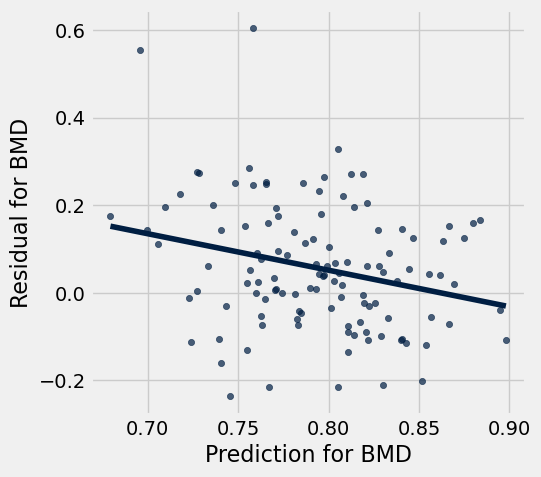

In [140]:
# Plot for fractures
BMD_with_fracture.scatter('Prediction for BMD', 'Residual for BMD', fit_line = True)

In [141]:
BMD_without_fracture = BMD_with_residuals.where('fracture', 'fracture')

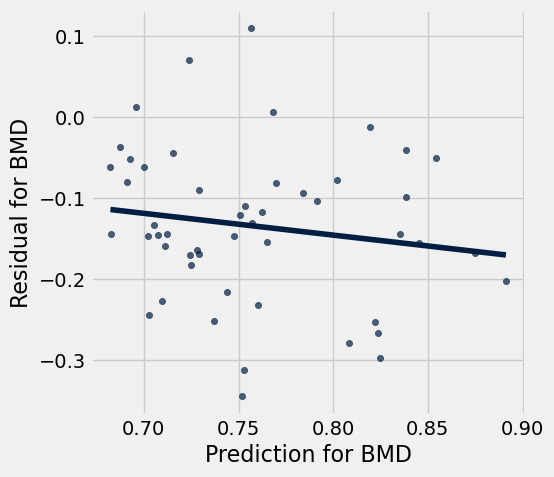

In [142]:
# Plot for no fractures
BMD_without_fracture.scatter('Prediction for BMD', 'Residual for BMD', fit_line = True)

**For both plots there is a similar downward slope, but in BMD with fracture the slope is steeper, while the BMD without fracture, the slope is not as steep**

## 3. Classification *(11 pts total)*

**Question 3.1** Construct a new table `BMD_classify` with four columns. The first three columns should be `bmd`, `age`, and `weight_kg` in standard units. The last column should be named `Class` and equal to the integer `1` for those that have had a fracture and equal to the integer `0` for those that have **not** had a fracture *(3 pts)*

In [143]:
def facture_or_not(fracture):
    if fracture == 'fracture':
        return 1
    
    elif fracture == 'no fracture':
        return 0

In [144]:
BMD_classify = Table().with_columns(
    'bmd SU', standard_units(BMD.column('bmd')),
    'age SU', standard_units(BMD.column('age')), 
    'weight_kg SU', standard_units(BMD.column('weight_kg')),
    'Class', BMD.apply(facture_or_not, 'fracture'))
BMD_classify

bmd SU,age SU,weight_kg SU,Class
0.579369,-0.533977,-0.0578702,0
0.0692374,0.982904,1.1592,0
0.744394,0.580128,0.724535,0
-0.433065,1.1863,-0.405606,0
0.0469529,-0.766186,-0.840276,0
-0.319234,1.0995,0.0290637,0
1.36414,-0.604766,1.07227,0
-0.313813,-1.11323,-0.49254,0
-0.564964,0.387723,-0.0578702,0
0.984705,0.213072,0.637601,0


**Question 3.2** Construct two new tables (`BMD_train` and `BMD_test`). Randomly assign (approximately) 80% of the data in `BMD_classify` to the training set and the remaining (approximately) 20% of the data to the testing set. *(3 pts)*

In [145]:
np.round(169*.8)


135.0

In [146]:
# do not change the line of code below
np.random.seed(1236514109)
# do not change the line of code above


class_shuffle = BMD_classify.sample(with_replacement = False)
BMD_train = class_shuffle.take(np.arange(0, 135))
BMD_test = class_shuffle.take(np.arange(135, 169))

**Question 3.3** Use the training data set to classify the first person in your testing data set as either `1` or `0` (corresponding to `fracture` or `no fracture`) by implementing a k-Nearest Neighbors algorithm (with k=5). Assign this value to `fracture_classification`. Then evaluate the accuracy of this classification model and assign `fracture_accuracy` to the proportion of your testing data that is correctly classified *(5 pts)*

In [147]:
def distance(point1, point2):
    """Returns the distance between point1 and point2
    where each argument is an array 
    consisting of the coordinates of the point"""
    return np.sqrt(np.sum((point1 - point2)**2))

def all_distances(training, new_point):
    """Returns an array of distances
    between each point in the training set
    and the new point (which is a row of attributes)"""
    attributes = training.drop('Class')
    def distance_from_point(row):
        return distance(np.array(list(new_point)), np.array(list(row)))
    return attributes.apply(distance_from_point)

def table_with_distances(training, new_point):
    """Augments the training table 
    with a column of distances from new_point"""
    return training.with_column('Distance', all_distances(training, new_point))

def closest(training, new_point, k):
    """Returns a table of the k rows of the augmented table
    corresponding to the k smallest distances"""
    with_dists = table_with_distances(training, new_point)
    sorted_by_distance = with_dists.sort('Distance')
    topk = sorted_by_distance.take(np.arange(k))
    return topk

def majority(topkclasses):
    ones = topkclasses.where('Class', are.equal_to(1)).num_rows
    zeros = topkclasses.where('Class', are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0

def classify(training, new_point, k):
    closestk = closest(training, new_point, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

In [148]:
def evaluate_accuracy(training, test, k):
    """Return the proportion of correctly classified examples 
    in the test set"""
    test_attributes = test.drop('Class')
    num_correct = 0
    for i in np.arange(test.num_rows):
        c = classify(training, test_attributes.row(i), k)
        num_correct = num_correct + (c == test.column('Class').item(i))
    return num_correct / test.num_rows

In [149]:
first_test_row = make_array(BMD_test.row(0).item(0), BMD_test.row(0).item(1), BMD_test.row(0).item(2))
first_test_row

array([ 1.41232455,  0.34852966, -0.23173812])

In [150]:
fracture_classification = classify(BMD_train, first_test_row, 5)

fracture_accuracy = evaluate_accuracy(BMD_train, BMD_test, 5)

fracture_classification, fracture_accuracy

(0, 0.8529411764705882)